# Simple FEM for one dimensional heat transfer problem

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import skfem as fem
from skfem.helpers import dot, grad
from skfem.visuals.matplotlib import draw, plot

from global_constants import L, alpha

# Mesh
N = 30
mesh = fem.MeshLine(np.linspace(0, L, N))
mesh = mesh.with_boundaries({"left": lambda x: x == 0})
print(mesh)


<skfem MeshLine1 object>
  Number of elements: 29
  Number of vertices: 30
  Number of nodes: 30
  Named boundaries [# facets]: left [1]


## Create the FEM function space

In [20]:
# Define first order line elements
element = fem.ElementLineP2()

# Function space
basis = fem.Basis(mesh, element)
x = basis.doflocs[0]

Assuming a constant heat conductivity, the function we want to solve is 

$$
\frac{\partial T}{\partial t} + \alpha \Delta T = 0.
$$

It's weak form is 

$$ 
 \int_\Omega \frac{\partial T}{\partial t} v dV  + \int_\Omega \alpha \nabla T \cdot \nabla v dV = 0.
$$

In [21]:
@fem.BilinearForm
def a(T, v, _):
    return alpha * dot(grad(T), grad(v))

@fem.BilinearForm
def c(T_dot, v, _):
    return T_dot * v

## Initial conditions

In [22]:
T = basis.zeros()
T[x<0.5] = 1.0

## Assemble
Assemble the system to a linear algebra equation for the solution vector $T$

$$
 \bm{C} \dot{T} + \bm{A} T = 0
$$

In [23]:
# Assemble matrices
A = fem.asm(a, basis)
C = fem.asm(c, basis)

## Integrate in time 
Crank-Nicholson time discretization yields 

$$ 
 [\bm{C} + \frac{1}{2} \Delta t \bm{A}] T^{n+1} = \bm{C} T^n - \frac{1}{2}  \Delta t \bm{A} T^n
$$

for the unknown vector $T^{n+1}$. This can be reformulated to 
$$ 
 \bm{K} T^{n+1} = \bm{b}
$$

with $\bm{K} = \bm{C} + \frac{1}{2} \Delta t \bm{A}$ and $\bm{b} = \bm{C} T^n - \frac{1}{2}  \Delta t \bm{A} T^n $.

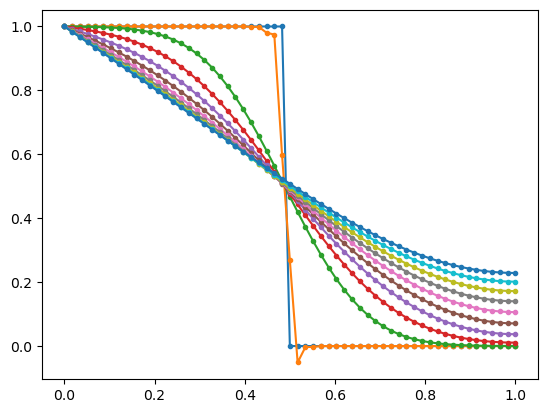

In [24]:
dt = 1e-4
t = 0
results = [T]
for i in range(1000):
    t = t + dt
    # Remove prescribed DoFs
    K = C + 0.5 * dt * A
    b = C @ T - 0.5 * dt * A @ T
    D = basis.get_dofs({"left"})
    T = fem.solve(*fem.condense(K, b, D=D, x=T))
    if i%100 == 0:
        results.append(T)

for res in results:
    sorted = np.argsort(x)
    plt.plot(x[sorted], res[sorted], ".-")
